# Dynamic characterization
This notebook is meant to explain the options for dynamic characterization in `timex_lca`.
In this example, there is a very simple database containing only one node with a pulse emission of CH4, occuring at a 10 year delay.

Further down, there is an example with multiple greenhouse gases.


In [1]:
import bw2data as bd
import numpy as np
from bw_temporalis import TemporalDistribution

project_name = "timex_minimal_example"
if project_name in bd.projects:
    bd.projects.delete_project(project_name)  # making sure to start from scratch
    bd.projects.purge_deleted_directories()

bd.projects.set_current(project_name)

bd.Database("biosphere").write(
    {
        ("biosphere", "X"): {
            "type": "emission",
            "name": "X",
        },
    }
)

bd.Database("background_t0").write(  # dummy system containing 1 activity
    {
        ("background_t0", "B"): {
            "name": "B",
            "location": "somewhere",
            "reference product": "B",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("background_t0", "B"),
                },
                {
                    "amount": 5,
                    "type": "biosphere",
                    "input": ("biosphere", "X"),
                    "temporal_distribution": TemporalDistribution(
                        date=np.array([0, 1], dtype="timedelta64[Y]"),
                        amount=np.array([0.6, 0.4]),
                    ),  # emission of CH4 10 years after execution of process A
                },
            ],
        },
    }
)

bd.Database("background_t1").write(  # dummy system containing 1 activity
    {
        ("background_t1", "B"): {
            "name": "B",
            "location": "somewhere",
            "reference product": "B",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("background_t1", "B"),
                },
                {
                    "amount": 3,
                    "type": "biosphere",
                    "input": ("biosphere", "X"),
                    "temporal_distribution": TemporalDistribution(
                        date=np.array([0, 1], dtype="timedelta64[Y]"),
                        amount=np.array([0.6, 0.4]),
                    ),  # emission of CH4 10 years after execution of process A
                },
            ],
        },
    }
)

bd.Database("foreground").write(  # dummy system containing 1 activity
    {
        ("foreground", "A"): {
            "name": "A",
            "location": "somewhere",
            "reference product": "A",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("foreground", "A"),
                },
                {
                    "amount": 2,
                    "type": "technosphere",
                    "input": ("background_t0", "B"),
                    "temporal_distribution": TemporalDistribution(
                        date=np.array([0, 1], dtype="timedelta64[Y]"),
                        amount=np.array([0.2, 0.8]),
                    ),
                },
            ],
        },
    }
)

bd.Method(("some", "method")).write(
    [
        (("biosphere", "X"), 1),  # GWP100 from IPCC AR6
    ]
)

100%|██████████| 1/1 [00:00<00:00, 12052.60it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<00:00, 25115.59it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]

Vacuuming database 


We select the demand and the method and calculate a LCA with `timex_lca`


In [2]:
demand = {("foreground", "A"): 1}
gwp = ("some", "method")

In [3]:
from datetime import datetime

database_date_dict = {
    "background_t0": datetime.strptime("2024", "%Y"),
    "background_t1": datetime.strptime("2025", "%Y"),
    "foreground": "dynamic",  # flag databases that should be temporally distributed with "dynamic"
}

In [4]:
from timex_lca import TimexLCA

tlca = TimexLCA(demand, gwp, database_date_dict)

In [5]:
tlca.build_timeline()

Calculation count: 1


/Users/timodiepers/Documents/Coding/timex/timex_lca/timex_lca.py:182: UserWarning: No edge filter function provided. Skipping all edges within background databases.
  warnings.warn(


,date_producer,producer_name,date_consumer,consumer_name,amount,interpolation_weights
0,2024-01-01,B,2024-01-01,A,0.4,{'background_t0': 1}
1,2024-01-01,A,2024-01-01,-1,1.0,None
2,2025-01-01,B,2024-01-01,A,1.6,{'background_t1': 1}


In [6]:
tlca.lci()

In [7]:
tlca.static_lcia()
tlca.static_score

6.800000000000001

In [8]:
tlca.create_labelled_technosphere_dataframe()

,"((background_t0, B), 2024)","((background_t1, B), 2025)","((foreground, A), dynamic)","((foreground, A), 2024)","((temporal market, B), 2025)"
"((background_t0, B), 2024)",1.0,0.0,-2.0,-0.4,0.0
"((background_t1, B), 2025)",0.0,1.0,0.0,0.0,-1.0
"((foreground, A), dynamic)",0.0,0.0,1.0,0.0,0.0
"((foreground, A), 2024)",0.0,0.0,0.0,1.0,0.0
"((temporal market, B), 2025)",0.0,0.0,0.0,-1.6,1.0


In [10]:
tlca.create_labelled_biosphere_dataframe()

,"((background_t0, B), 2024)","((background_t1, B), 2025)","((foreground, A), dynamic)","((foreground, A), 2024)","((temporal market, B), 2025)"
"(biosphere, X)",5.0,3.0,0.0,0.0,0.0


In [17]:
tlca.dynamic_inventory_df

,date,amount,flow,activity
0,2024-01-01,2.72,1,2
1,2025-01-01,4.80,1,2


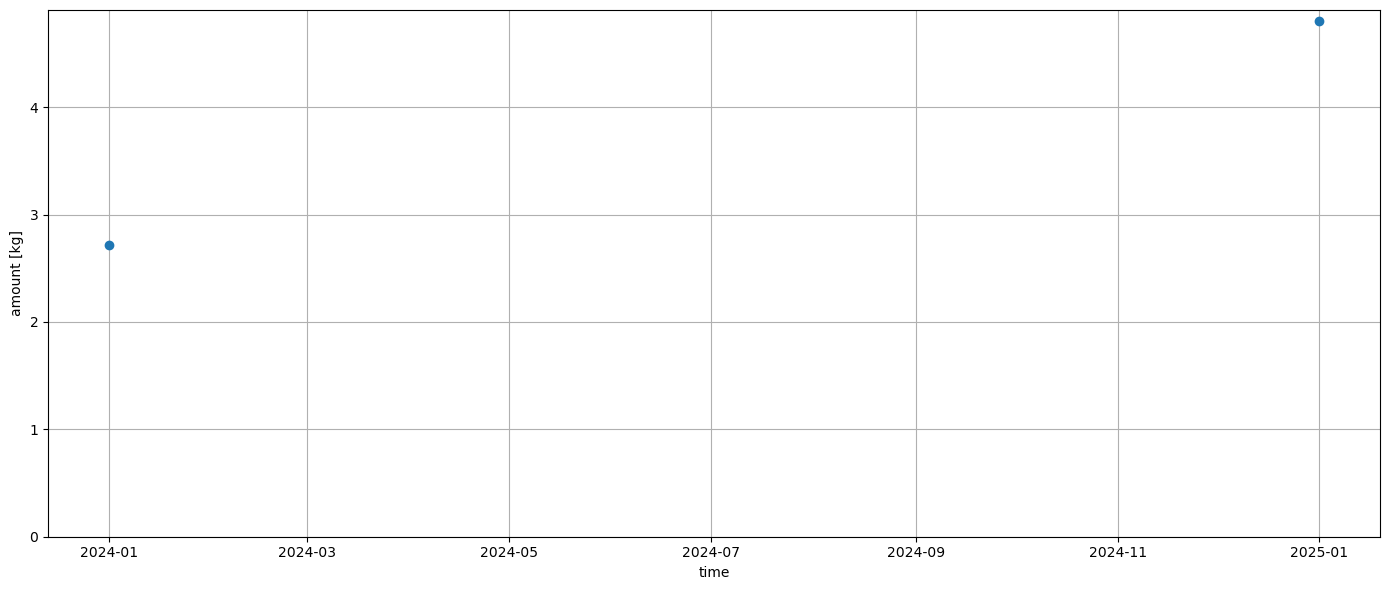

In [15]:
tlca.plot_dynamic_inventory([1])